In [217]:
# Import library
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# ml
from sklearn import linear_model
from sklearn.model_selection import KFold

# numbers
import numpy as np
import pandas as pd

# stats
import statsmodels.api as sm
import scipy.stats as stats

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re

In [ ]:
def abalone_load(data_file, infant=False):
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # data
    df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)
    
    if(infant):
        new_df = df[ df['Sex']=='I' ]
    else:
        new_df = df[ df['Sex']<>'I' ]
    return new_df

def infant_abalone_load(data_file):
    return abalone_load(data_file,True)

def adult_abalone_load(data_file):
    return abalone_load(data_file,False)

def abalone_removeoutliers(df,mse_tol,verbose=False):
    df.loc[:,'Volume'] = df['Length'].values*df['Diameter'].values*df['Height'].values

    X = df['Volume']
    Y = df['Shell weight']
    lin = sm.OLS(Y,X).fit()

    Yhat = lin.predict(df['Volume'])
    df.loc[:,'Predicted shell weight'] = Yhat
    df.loc[:,'Residual'] = Y - Yhat
    df.loc[:,'MSE'] = (Y - Yhat)**2
    MSE = df['MSE']

    thresh = 0.5
    new_df = df[df['MSE'] < thresh]
    records_removed = len(df) - len(new_df)
    
    if(verbose):
        print "Number of data points removed: %d"%(records_removed)
        print "%0.2f%% of data was removed"%((float(records_removed)/len(df))*100)
    
    del df['Predicted shell weight']
    del df['Residual']
    del df['MSE']
    
    return df

def infant_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,0.5)
    
def adult_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,1.0)

In [212]:
# Import dataset
#path ='dataset/'

df = pd.read_csv('abalone.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [213]:
# x data labels
xnlabs = ['Sex']
xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
xlabs = xnlabs + xqlabs

# y data labels
ylabs = ['Rings']

In [214]:
print(xlabs)

['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']


In [216]:
print(ylabs)

['Rings']


In [218]:
lmreg = linear_model.LinearRegression( fit_intercept = False )
lmreg.fit( df[xqlabs], df[ylabs] )

LinearRegression(fit_intercept=False)

In [219]:
lmreg.coef_

array([[  6.25118544,  13.26256033,  14.51597929,   8.83581543,
        -21.16645562, -11.71397538,   6.59129703]])

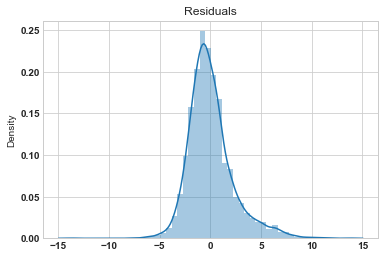

In [221]:
# Compute residuals 
yhat = lmreg.predict(df[xqlabs])
lmresid = df[ylabs] - yhat
sns.distplot(lmresid)
plt.title('Residuals')

plt.show()

In [222]:
lmreg.score(df[xqlabs],df[ylabs])

0.513689649516864

In [224]:
mean = df['Rings'].mean()
var = np.sqrt(df['Rings'].var())
print("scikit-learn linear regression model:")
print("mean response value = %0.2f"%(mean))
print("L2 residual = %0.2f"%(var))

scikit-learn linear regression model:
mean response value = 9.93
L2 residual = 3.22


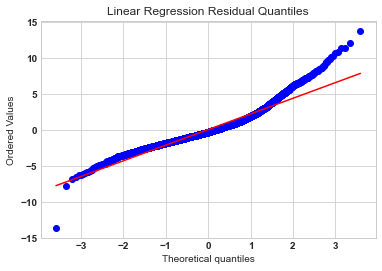

In [225]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

stats.probplot(lmresid['Rings'].values, dist='norm',plot=ax1)
ax1.set_title('Linear Regression Residual Quantiles')
plt.show()

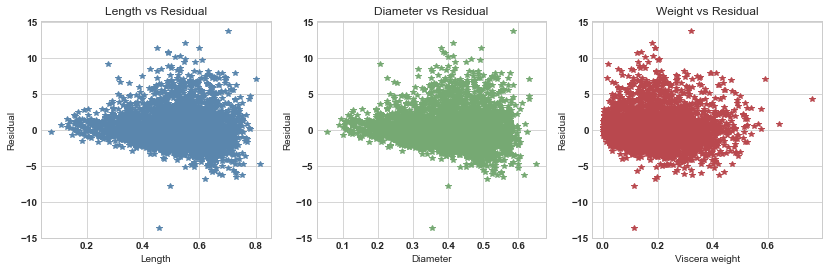

In [226]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

ax1.plot(df['Length'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty blue'])
ax1.set_xlabel('Length')
ax1.set_ylabel('Residual')
ax1.set_title('Length vs Residual')

ax2.plot(df['Diameter'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty green'])
ax2.set_xlabel('Diameter')
ax2.set_ylabel('Residual')
ax2.set_title('Diameter vs Residual')

ax3.plot(df['Viscera weight'],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty red'])
ax3.set_xlabel('Viscera weight')
ax3.set_ylabel('Residual')
ax3.set_title('Weight vs Residual')

plt.show()

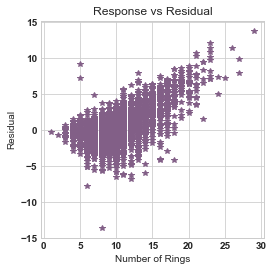

In [227]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4))

ax1.plot(df[ylabs],lmresid['Rings'],'*', color=sns.xkcd_rgb['dusty purple'])
ax1.set_xlabel('Number of Rings')
ax1.set_ylabel('Residual')
ax1.set_title('Response vs Residual')

plt.show()

In [228]:
import statsmodels.api as sm

In [230]:
olm = sm.OLS(df[ylabs], df[xqlabs]).fit()
print(olm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Rings   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.226e+04
Date:                Sun, 03 Jan 2021   Prob (F-statistic):                        0.00
Time:                        23:49:49   Log-Likelihood:                         -9310.7
No. Observations:                4177   AIC:                                  1.864e+04
Df Residuals:                    4170   BIC:                                  1.868e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------